In [1]:
import pandas as pd
import numpy as np
from collections import Counter

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Setting toolkit folder as working directory

%cd #Your path
! ls

/content/drive/MyDrive/[001]-TEC/MCC/Tesis/Sentiment Analysis/thesis-project-sent-analysis/anomaly-detection
1-svm-thesis-project.ipynb  player-dataset-complete-v3.csv	player-datset-1.csv
clasificadores-exp.ipynb    player-dataset-wg-avg.csv		player-datset-2.csv
Classifiers-test.ipynb	    player-dataset-wg-avg-expirado.csv	Preliminary-results-TP.gsheet
player-dataset-avg.csv	    player-datset-0.csv			svm.py


## Data manipulation

In [ ]:
df = pd.read_csv('your-file.csv')
print(len(df[df['Pos'] == 'GK']))
df = df[df['Pos'] != 'GK'] # Excludes Goalkeepers
df.dropna(subset=['Pos'], inplace=True)
df.reset_index(drop=True, inplace=True)
print(len(df[df['Pos'] == 'GK']))
df = df.fillna(0)
X = df.iloc[:,3:-1]
y = df.iloc[:,-1]
mayority_class = sorted(Counter(y).items())[0][1]
minority_class = sorted(Counter(y).items())[1][1]
ratio = minority_class/(mayority_class + minority_class)
print(f"The dataset has {mayority_class} records for the majority class and {minority_class} records for the minority class.")
print(f'Resulting in {ratio} percentage of the minority class in the entire dataset.')

61
0
The dataset has 1031 records for the majority class and 55 records for the minority class.
Resulting in 0.05064456721915286 percentage of the minority class in the entire dataset.


<ipython-input-14-60771187b21a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['Pos'], inplace=True)


In [16]:
print(len(X.columns))
X.columns

14


Index(['wg_avg_mp', 'wg_avg_min', 'wg_avg_gls', 'wg_avg_asst',
       'wg_avg_gls_asst', 'wg_avg_value', 'wg_avg_ovrl', 'wg_avg_pot',
       'wg_avg_pac', 'wg_avg_sho', 'wg_avg_pas', 'wg_avg_dri', 'wg_avg_def',
       'wg_avg_phy'],
      dtype='object')

## Train Test Split

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

# Standarization
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Check the number of records
print('The number of records in the training dataset is', X_train.shape[0])
print('The number of records in the test dataset is', X_test.shape[0])
print(f"The training dataset has {sorted(Counter(y_train).items())[0][1]} records for the majority class and {sorted(Counter(y_train).items())[1][1]} records for the minority class.")

The number of records in the training dataset is 868
The number of records in the test dataset is 218
The training dataset has 825 records for the majority class and 43 records for the minority class.


# Supervised Learning Algorithms

## Setting environment

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, get_scorer_names
import matplotlib.pyplot as plt
import seaborn as sns

# MODELOS
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# CROSS-VALIDATION FOR FINE TUNNING
from sklearn.model_selection import GridSearchCV

# CROSS-VALIDATION FOR COMPARISON
from sklearn.model_selection import cross_val_score


## SMOTE

Synthetic Minority Over-sampling Technique for handling imbalanced datasets

In [ ]:
# Apply SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [ ]:
X_train_res

,wg_avg_mp,wg_avg_min,wg_avg_gls,wg_avg_asst,wg_avg_gls_asst,wg_avg_value,wg_avg_ovrl,wg_avg_pot,wg_avg_pac,wg_avg_sho,wg_avg_pas,wg_avg_dri,wg_avg_def,wg_avg_phy
0,16.690000,1226.860000,2.830000,0.000000,2.830000,8.983348e+05,46.780000,50.260000,39.660000,22.660000,31.090000,30.280000,46.980000,47.990000
1,5.100000,120.010000,4.230000,4.230000,5.060000,1.925012e+05,42.540000,46.900000,53.940000,40.190000,35.750000,43.220000,19.100000,47.700000
2,29.360000,2462.700000,-2.620000,2.360000,4.420000,1.341667e+06,48.080000,52.020000,48.040000,44.360000,46.900000,48.520000,41.300000,45.500000
3,1.030000,547.800000,0.230000,0.000000,0.230000,3.499998e+05,45.030000,52.680000,46.200000,20.820000,32.650000,35.450000,43.850000,51.810000
4,18.200000,784.580000,1.140000,-3.890000,1.490000,6.183333e+06,51.160000,56.450000,55.780000,48.130000,50.030000,53.900000,35.000000,44.370000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1645,16.225671,1376.097385,4.566587,0.552187,1.650713,1.501686e+06,47.159358,52.530320,59.126826,30.119929,42.579214,49.500679,44.965339,48.209287
1646,17.338059,1339.591054,0.785978,2.391971,4.003105,3.111747e+06,49.474418,55.885240,52.670853,34.468174,43.660523,46.073892,35.385615,46.391285
1647,22.802503,1815.443241,4.635012,1.457944,5.920800,2.831384e+06,49.119404,53.692113,54.672358,39.099832,44.835831,50.006323,39.743196,44.591402
1648,21.927329,1515.024160,3.464343,4.641759,7.149584,1.769793e+06,45.630796,49.789849,56.429188,37.744814,40.089202,46.233625,22.403119,40.438938


In [ ]:
mayority_class = sorted(Counter(y_train_res).items())[0][1]
minority_class = sorted(Counter(y_train_res).items())[1][1]
ratio = minority_class/(mayority_class + minority_class)
print(f"The dataset has {mayority_class} records for the majority class and {minority_class} records for the minority class.")
print(f'Resulting in {ratio} percentage of the minority class in the entire dataset.')

The dataset has 825 records for the majority class and 825 records for the minority class.
Resulting in 0.5 percentage of the minority class in the entire dataset.


## Random Forest

In [ ]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the grid search model ***** NO CORRER LA MEJOR CONFIGURACIÓN YA ESTÁ ABAJO *****
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='roc_auc', verbose=2, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train_res, y_train_res)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters: ", best_params)

NameError: name 'clf' is not defined

In [ ]:
# Train a new classifier using the best parameters found by the grid search
best_params = {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
clf_best = RandomForestClassifier(**best_params, random_state=42)
clf_best.fit(X_train_res, y_train_res)


RandomForestClassifier(bootstrap=False, n_estimators=400, random_state=42)

              precision    recall  f1-score   support

         0.0       0.96      0.97      0.96       206
         1.0       0.33      0.25      0.29        12

    accuracy                           0.93       218
   macro avg       0.65      0.61      0.62       218
weighted avg       0.92      0.93      0.93       218



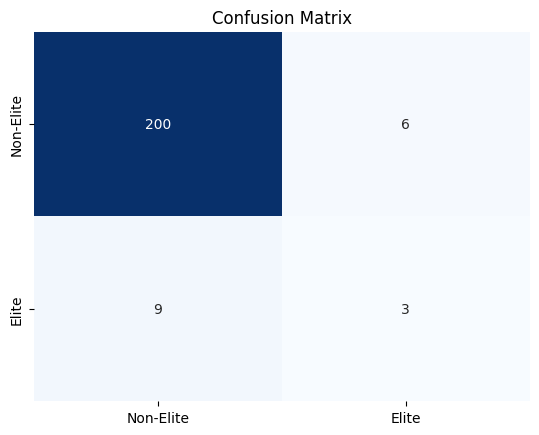

ROC AUC score:  0.6104368932038835


In [ ]:
# Make predictions
y_pred = clf_best.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))

# Print confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cbar=False, fmt='d', cmap='Blues', xticklabels=['Non-Elite', 'Elite'], yticklabels=['Non-Elite', 'Elite'])
plt.title('Confusion Matrix')
plt.show()

# Print ROC AUC score
print('ROC AUC score: ', roc_auc_score(y_test, y_pred))

In [ ]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the grid search model
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='roc_auc', verbose=2, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train_res, y_train_res)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters: ", best_params)

# Train a new classifier using the best parameters found by the grid search
clf_best = RandomForestClassifier(**best_params, random_state=42)
clf_best.fit(X_train_res, y_train_res)


### Cross-validation

[0.92709706 0.86871139 0.87731686 0.8729038  0.91460724]
Average AUC-ROC with SMOTE for Random Forest: 0.8921272667579127
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      1031
         1.0       0.39      0.35      0.37        55

    accuracy                           0.94      1086
   macro avg       0.68      0.66      0.67      1086
weighted avg       0.94      0.94      0.94      1086



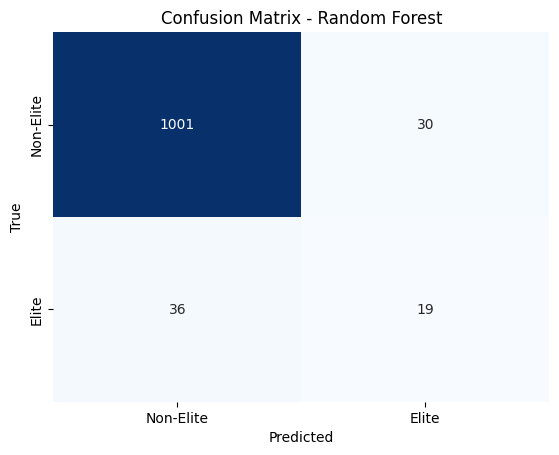

In [ ]:
best_params = {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.over_sampling import SMOTE

# Assuming X and y are your feature matrix and target variable
# Assuming best_params is your dictionary of hyperparameters

# Create the RandomForestClassifier with the best_params
clf_best = RandomForestClassifier(**best_params, random_state=42, class_weight='balanced')

# Specify the cross-validation strategy (StratifiedKFold is often used for classification tasks)
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create a pipeline with SMOTE and the classifier using imbalanced-learn's make_pipeline
pipeline_rf = make_imb_pipeline(SMOTE(random_state=42), clf_best)

# Perform cross-validation
cv_scores = cross_val_score(pipeline_rf, X, y, cv=cv_strategy, scoring='roc_auc')
print(cv_scores)

# Print the average AUC-ROC across folds
print("Average AUC-ROC with SMOTE for Random Forest:", cv_scores.mean())

# Perform cross-validated predictions
predicted_labels_rf = cross_val_predict(pipeline_rf, X, y, cv=cv_strategy)

# Print the classification report
print("Classification Report:\n", classification_report(y, predicted_labels_rf))

# Generate the confusion matrix
conf_matrix = confusion_matrix(y, predicted_labels_rf)

# Plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Elite', 'Elite'],
            yticklabels=['Non-Elite', 'Elite'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Random Forest')
plt.show()

In [ ]:
cv_scores

array([0.86918349, 0.95351368, 0.928949  , 0.92599502, 0.87088235])

### Feature Importance

In [ ]:
clf_best.fit(X_train_res, y_train_res)
# Get feature importances
importances_rf = clf_best.feature_importances_

# Convert importances to a DataFrame
importances_rf_df = pd.DataFrame({'feature': X.columns, 'importance': importances_rf})

# Sort DataFrame by importance
importances_rf_df = importances_rf_df.sort_values('importance', ascending=False)

# Print feature importances
print(importances_rf_df)


            feature  importance
5      wg_avg_value    0.274146
7        wg_avg_pot    0.174015
6       wg_avg_ovrl    0.104693
10       wg_avg_pas    0.080762
11       wg_avg_dri    0.060207
8        wg_avg_pac    0.050463
13       wg_avg_phy    0.041892
9        wg_avg_sho    0.037607
1        wg_avg_min    0.035120
0         wg_avg_mp    0.032268
3       wg_avg_asst    0.030370
4   wg_avg_gls_asst    0.029456
2        wg_avg_gls    0.029233
12       wg_avg_def    0.019769


## Gradient Boosting

### Main GB

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       206
         1.0       0.45      0.42      0.43        12

    accuracy                           0.94       218
   macro avg       0.71      0.69      0.70       218
weighted avg       0.94      0.94      0.94       218



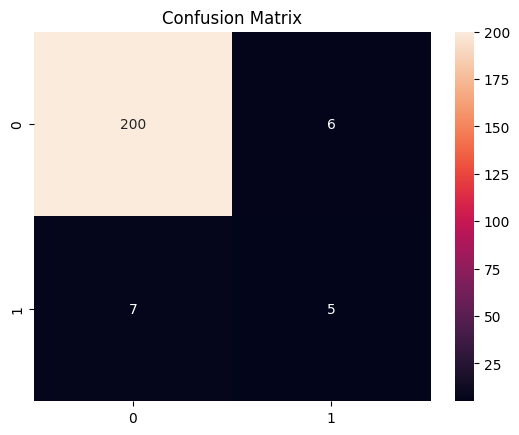

ROC AUC score:  0.6937702265372169


In [ ]:
# Initialize the model
best_params_gb = {'learning_rate': 0.3, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200, 'subsample': 0.7}
gb_best = GradientBoostingClassifier(**best_params_gb, random_state=42)
gb_best.fit(X_train_res, y_train_res)

# Train the model
gb_best.fit(X_train_res, y_train_res)

# Make predictions
y_pred_gb = gb_best.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred_gb))

# Print confusion matrix
cm_gb = confusion_matrix(y_test, y_pred_gb)
sns.heatmap(cm_gb, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()

# Print ROC AUC score
print('ROC AUC score: ', roc_auc_score(y_test, y_pred_gb))


In [ ]:
# Define the parameter grid
param_grid_gb = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.5, 0.7, 1]
}

# Initialize the grid search model
grid_search_gb = GridSearchCV(estimator=gb, param_grid=param_grid_gb, cv=5, scoring='roc_auc', verbose=2, n_jobs=-1)

# Fit the grid search to the data
grid_search_gb.fit(X_train_res, y_train_res)

# Get the best parameters
best_params_gb = grid_search_gb.best_params_
print("Best parameters: ", best_params_gb)


Fitting 5 folds for each of 3240 candidates, totalling 16200 fits


### Cross-validation GB

[0.92138779 0.89938217 0.86451898 0.86981465 0.90203001]
Average AUC-ROC with SMOTE for Gradient Boosting: 0.8914267197086951
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.96      0.97      1031
         1.0       0.39      0.44      0.41        55

    accuracy                           0.94      1086
   macro avg       0.68      0.70      0.69      1086
weighted avg       0.94      0.94      0.94      1086



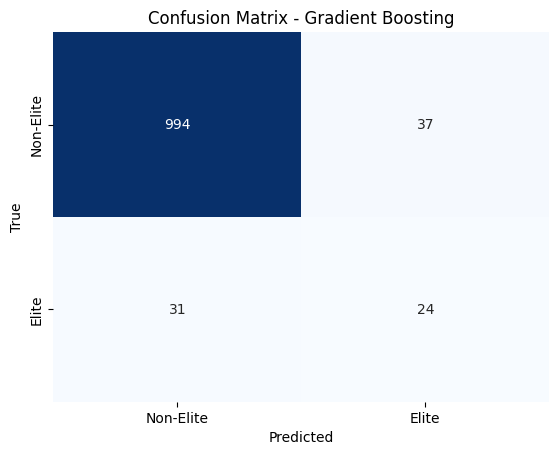

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix

# Train a new classifier using the best parameters found by the grid search
best_params_gb = {'learning_rate': 0.3, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200, 'subsample': 0.7}
gb_best = GradientBoostingClassifier(**best_params_gb, random_state=42)

# Specify the cross-validation strategy (StratifiedKFold is often used for classification tasks)
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create a pipeline with SMOTE and the classifier using imbalanced-learn's make_pipeline
pipeline_gb = make_imb_pipeline(SMOTE(random_state=42), gb_best)

# Perform cross-validation
cv_scores_gb = cross_val_score(pipeline_gb, X, y, cv=cv_strategy, scoring='roc_auc')
print(cv_scores_gb)

# Print the average AUC-ROC across folds
print("Average AUC-ROC with SMOTE for Gradient Boosting:", cv_scores_gb.mean())

# Perform cross-validated predictions
predicted_labels_gb = cross_val_predict(pipeline_gb, X, y, cv=cv_strategy)

# Print the classification report
print("Classification Report:\n", classification_report(y, predicted_labels_gb))

# Generate the confusion matrix
conf_matrix = confusion_matrix(y, predicted_labels_gb)

# Plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Elite', 'Elite'],
            yticklabels=['Non-Elite', 'Elite'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Gradient Boosting')
plt.show()


### Feature Importance

In [ ]:
gb_best.fit(X_train_res, y_train_res)
# Get feature importances
importances_gb = gb_best.feature_importances_

# Convert importances to a DataFrame
importances_gb_df = pd.DataFrame({'feature': X.columns, 'importance': importances_gb})

# Sort DataFrame by importance
importances_gb_df = importances_gb_df.sort_values('importance', ascending=False)

# Print feature importances
print(importances_gb_df)


            feature  importance
5      wg_avg_value    0.561679
10       wg_avg_pas    0.101275
7        wg_avg_pot    0.071468
3       wg_avg_asst    0.048159
13       wg_avg_phy    0.035066
4   wg_avg_gls_asst    0.032205
1        wg_avg_min    0.029923
9        wg_avg_sho    0.024917
6       wg_avg_ovrl    0.020061
0         wg_avg_mp    0.018570
2        wg_avg_gls    0.018421
11       wg_avg_dri    0.017625
8        wg_avg_pac    0.014430
12       wg_avg_def    0.006203


## Support Vector Machine

### Main SVM

Best parameters:  {'C': 10, 'gamma': 0.001}
              precision    recall  f1-score   support

         0.0       0.95      0.39      0.56       206
         1.0       0.06      0.67      0.11        12

    accuracy                           0.41       218
   macro avg       0.51      0.53      0.33       218
weighted avg       0.90      0.41      0.53       218



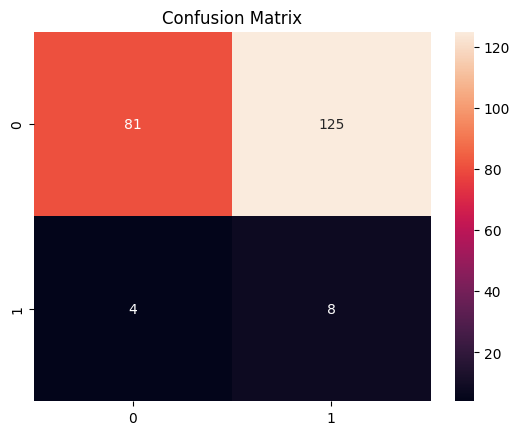

ROC AUC score:  0.5299352750809061


In [ ]:
from sklearn.svm import SVC

best_params_svc = {'C': 10, 'gamma': 0.001}
print("Best parameters: ", best_params_svc)

# Train a new classifier using the best parameters found by the grid search
svc_best = SVC(**best_params_svc, random_state=42, class_weight='balanced', probability=True)

# Initialize the model
# svc_best = SVC(C=1, gamma='scale', random_state=42, class_weight='balanced', )

# Train the model
svc_best.fit(X_train_res, y_train_res)

# Make predictions
y_pred_svc = svc_best.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred_svc))

# Print confusion matrix
cm_svc = confusion_matrix(y_test, y_pred_svc)
sns.heatmap(cm_svc, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()

# Print ROC AUC score
print('ROC AUC score: ', roc_auc_score(y_test, y_pred_svc))

### Cross-validation SVM

Best parameters:  {'C': 10, 'gamma': 0.001}
[0.93895477 0.92806708 0.91482789 0.80141218 0.96337158]
Average AUC-ROC with SMOTE: 0.9093266988159348
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.90      0.94      1031
         1.0       0.30      0.78      0.44        55

    accuracy                           0.90      1086
   macro avg       0.65      0.84      0.69      1086
weighted avg       0.95      0.90      0.92      1086



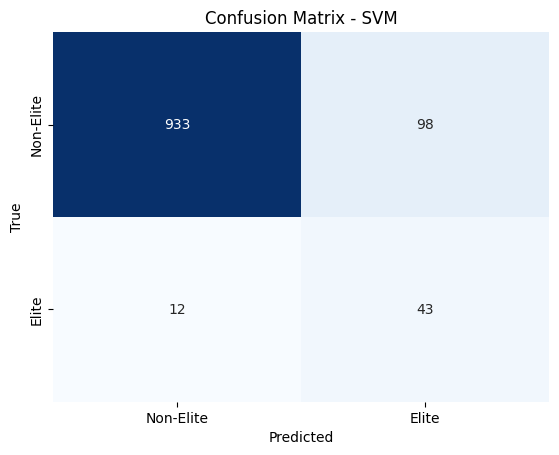

In [ ]:
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC

best_params_svc = {'C': 10, 'gamma': 0.001}
print("Best parameters: ", best_params_svc)

# Train a new classifier using the best parameters found by the grid search
svc_best = SVC(**best_params_svc, random_state=42, class_weight='balanced', probability=True)

# Specify the cross-validation strategy (StratifiedKFold is often used for classification tasks)
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create a pipeline with SMOTE and the classifier using imbalanced-learn's make_pipeline
pipeline_svc = make_imb_pipeline(SMOTE(random_state=42), StandardScaler(), svc_best)

# Perform cross-validation
cv_scores_svc = cross_val_score(pipeline_svc, X, y, cv=cv_strategy, scoring='roc_auc')
print(cv_scores_svc)

# Print the average AUC-ROC across folds
print("Average AUC-ROC with SMOTE:", cv_scores_svc.mean())

# Perform cross-validated predictions
predicted_labels_svc = cross_val_predict(pipeline_svc, X, y, cv=cv_strategy)

# Print the classification report
print("Classification Report:\n", classification_report(y, predicted_labels_svc))

# Generate the confusion matrix
conf_matrix = confusion_matrix(y, predicted_labels_svc)

# Plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Elite', 'Elite'],
            yticklabels=['Non-Elite', 'Elite'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - SVM')
plt.show()

### Feature Importance

In [ ]:
from sklearn.inspection import permutation_importance

svc_best.fit(X_train_res, y_train_res)
# Perform permutation importance
results = permutation_importance(svc_best, X_test, y_test, scoring='roc_auc')

# Get importance
importance = results.importances_mean

# Summarize feature importance
for i, j in enumerate(importance):
    print('Feature %d: %s, Score: %.5f' % (i, X.columns[i], j))


Feature 0: wg_avg_mp, Score: 0.00121
Feature 1: wg_avg_min, Score: 0.04830
Feature 2: wg_avg_gls, Score: 0.00000
Feature 3: wg_avg_asst, Score: 0.00000
Feature 4: wg_avg_gls_asst, Score: -0.00016
Feature 5: wg_avg_value, Score: 0.18265
Feature 6: wg_avg_ovrl, Score: 0.00364
Feature 7: wg_avg_pot, Score: 0.00485
Feature 8: wg_avg_pac, Score: 0.00316
Feature 9: wg_avg_sho, Score: 0.00348
Feature 10: wg_avg_pas, Score: 0.00388
Feature 11: wg_avg_dri, Score: 0.00243
Feature 12: wg_avg_def, Score: 0.00218
Feature 13: wg_avg_phy, Score: 0.00413


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area for each class

fpr_rf, tpr_rf, _ = roc_curve(y_test, clf_best.predict_proba(X_test)[:, 1])
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_gb, tpr_gb, _ = roc_curve(y_test, gb_best.predict_proba(X_test)[:, 1])
roc_auc_gb = auc(fpr_gb, tpr_gb)

fpr_svc, tpr_svc, _ = roc_curve(y_test, svc_best.decision_function(X_test))
roc_auc_svc = auc(fpr_svc, tpr_svc)

# Plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=lw, label='Random Forest (area = %0.2f)' % roc_auc_rf)
plt.plot(fpr_gb, tpr_gb, color='green', lw=lw, label='Gradient Boosting (area = %0.2f)' % roc_auc_gb)
plt.plot(fpr_svc, tpr_svc, color='blue', lw=lw, label='SVM (area = %0.2f)' % roc_auc_svc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


NameError: name 'y_test' is not defined

# Unsupervised learning

## Isolation Forest



* Isolation Forest is an ensemble-based algorithm that works by randomly selecting features and creating isolation trees to isolate anomalies. Anomalies are expected to be isolated faster than normal instances.
* It is particularly effective for high-dimensional datasets and is less sensitive to outliers in the majority class.
* For this we're using a "Supervised Variant" where you train the model only on normal instances and then identify instances with lower outlier scores as anomalies



### Without Standarization:

In [ ]:
mayority_class = sorted(Counter(y_train).items())[0][1]
minority_class = sorted(Counter(y_train).items())[1][1]
ratio = minority_class/(mayority_class + minority_class)

# Check the number of records
print('The number of records in the training dataset is', X_train.shape[0])
print('The number of records in the test dataset is', X_test.shape[0])
print(f"The training dataset has {sorted(Counter(y_train).items())[0][1]} \
records for the majority class and {sorted(Counter(y_train).items())[1][1]} \
records for the \nminority class, resulting in {ratio} percentage of the minority class in the entire dataset.")

The number of records in the training dataset is 917
The number of records in the test dataset is 230
The training dataset has 852 records for the majority class and 65 records for the 
minority class, resulting in 0.07088331515812432 percentage of the minority class in the entire dataset.


In [ ]:
from sklearn.ensemble import IsolationForest

# Create the Isolation Forest model
model_IsFo = IsolationForest(contamination=0.07)  # Set contamination based on the percentage of anomalies in your dataset

# Train the model
model_IsFo.fit(X_train)  # X_train is your training data

# Predict anomalies
predictions = model_IsFo.predict(X_test)  # X_test is your test data



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

# Change the anomalies' values to make it consistent with the true values
predictions_IsFo = [1 if i==-1 else 0 for i in predictions_IsFo]
print(classification_report(y_test, predictions_IsFo))

# Calculate AUC-ROC
auc_roc = roc_auc_score(y_test, predictions_IsFo)
print(f'AUC-ROC: {auc_roc:.4f}')


              precision    recall  f1-score   support

           0       0.94      0.93      0.94       211
           1       0.30      0.32      0.31        19

    accuracy                           0.88       230
   macro avg       0.62      0.62      0.62       230
weighted avg       0.89      0.88      0.88       230

AUC-ROC: 0.6247


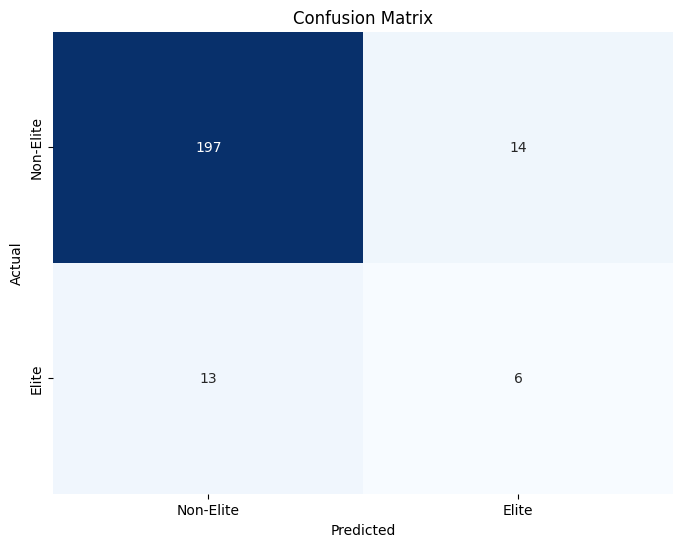

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, predictions_IsFo)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cbar=False, fmt='d', cmap='Blues', xticklabels=['Non-Elite', 'Elite'], yticklabels=['Non-Elite', 'Elite'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### With Standarization:

In [ ]:
from sklearn.ensemble import IsolationForest

# Create the Isolation Forest model
model_IsFo_scaled = IsolationForest(contamination=0.07)  # Set contamination based on the percentage of anomalies in your dataset

# Train the model
model_IsFo_scaled.fit(X_train_scaled)  # X_train is your training data

# Predict anomalies
predictions_IsFo_scaled = model_IsFo_scaled.predict(X_test_scaled)  # X_test is your test data



In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

# Change the anomalies' values to make it consistent with the true values
predictions_IsFo_scaled = [1 if i==-1 else 0 for i in predictions_IsFo_scaled]
print(classification_report(y_test, predictions_IsFo_scaled))

# Calculate AUC-ROC
auc_roc = roc_auc_score(y_test, predictions_IsFo_scaled)
print(f'AUC-ROC: {auc_roc:.4f}')


              precision    recall  f1-score   support

           0       0.93      0.93      0.93       211
           1       0.22      0.21      0.22        19

    accuracy                           0.87       230
   macro avg       0.58      0.57      0.57       230
weighted avg       0.87      0.87      0.87       230

AUC-ROC: 0.5721


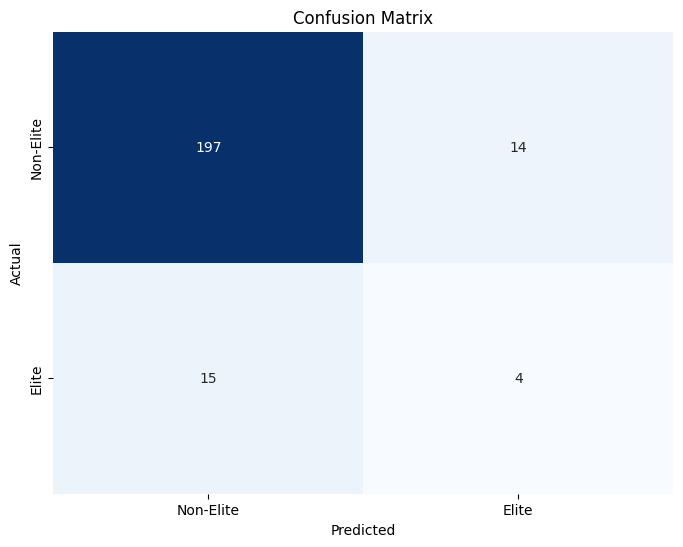

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, predictions_IsFo_scaled)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cbar=False, fmt='d', cmap='Blues', xticklabels=['Non-Elite', 'Elite'], yticklabels=['Non-Elite', 'Elite'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.ensemble import IsolationForest

# Create the Isolation Forest model
model_IsFo_supervised_scaled = IsolationForest(contamination=0.07)  # Set contamination based on the percentage of anomalies in your dataset

# Train the model
model_IsFo_supervised_scaled.fit(X_train_scaled)  # X_train is your training data

# Predict anomalies
predictions_IsFo_scaled = model_IsFo_supervised_scaled.predict(X_test_scaled)  # X_test is your test data

## One-Class SVM



* One-Class SVM is a machine learning algorithm that is trained only on the normal instances. It learns a boundary that encapsulates the normal data, and instances outside this boundary are considered anomalies.
* It's useful for situations where you have mostly normal instances and want to detect rare anomalies.
* Sandarization can be crucial in this algorithm.



In [ ]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report, roc_auc_score

# Create One-Class Support Vector Machine model
model_svm = OneClassSVM(nu=0.05)
model_svm.fit(X_train)

# Predict anomalies
predictions_svm = model_svm.predict(X_test)

In [ ]:
# Change the anomalies' values to make it consistent with the true values
predictions_svm = [1 if i==-1 else 0 for i in predictions_svm]
print(classification_report(y_test, predictions_svm))

# Calculate AUC-ROC
auc_roc = roc_auc_score(y_test, predictions_svm)
print(f'AUC-ROC: {auc_roc:.4f}')

              precision    recall  f1-score   support

           0       0.93      0.96      0.95       211
           1       0.33      0.21      0.26        19

    accuracy                           0.90       230
   macro avg       0.63      0.59      0.60       230
weighted avg       0.88      0.90      0.89       230

AUC-ROC: 0.5863


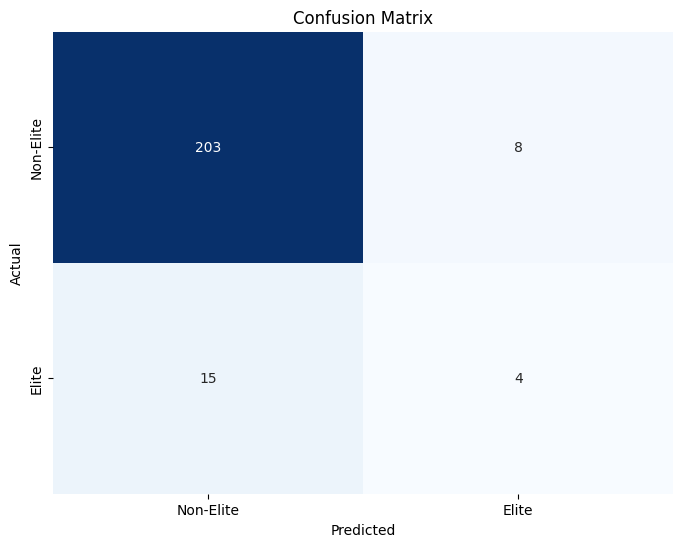

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, predictions_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cbar=False, fmt='d', cmap='Blues', xticklabels=['Non-Elite', 'Elite'], yticklabels=['Non-Elite', 'Elite'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report, roc_auc_score

# With standarization
model_svm_scaled = OneClassSVM(nu=0.05)  # Adjust nu based on your dataset
model_svm_scaled.fit(X_train_scaled)

# Predict anomalies
predictions_svm_scaled = model_svm_scaled.predict(X_test_scaled)

In [ ]:
# Change the anomalies' values to make it consistent with the true values
predictions_svm_scaled = [1 if i==-1 else 0 for i in predictions_svm_scaled]
print(classification_report(y_test, predictions_svm_scaled))

# Calculate AUC-ROC
auc_roc = roc_auc_score(y_test, predictions_svm_scaled)
print(f'AUC-ROC: {auc_roc:.4f}')

              precision    recall  f1-score   support

           0       0.93      0.94      0.93       211
           1       0.19      0.16      0.17        19

    accuracy                           0.87       230
   macro avg       0.56      0.55      0.55       230
weighted avg       0.86      0.87      0.87       230

AUC-ROC: 0.5481


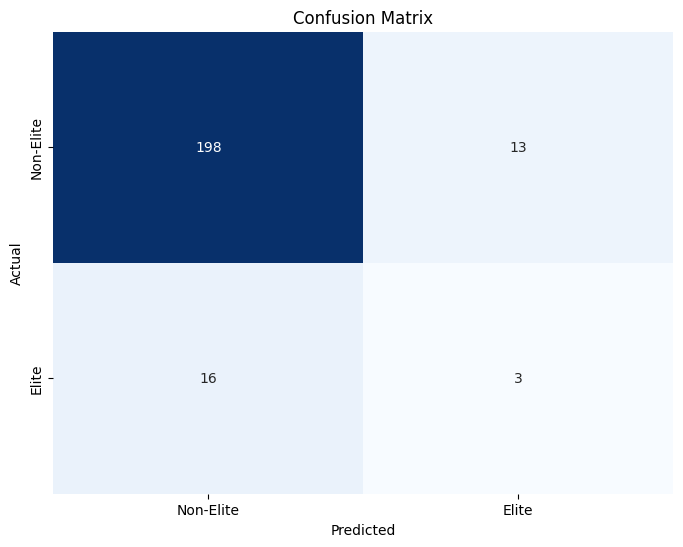

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, predictions_svm_scaled)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cbar=False, fmt='d', cmap='Blues', xticklabels=['Non-Elite', 'Elite'], yticklabels=['Non-Elite', 'Elite'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Local Outlier Factor



*   LOF measures the local density deviation of a data point with respect to its neighbors. Anomalies are identified as data points with significantly lower density compared to their neighbors.
* Not inherently sensitive to scale



In [ ]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report, roc_auc_score

# Train Local Outlier Factor (LOF)
model_lof = LocalOutlierFactor(n_neighbors=20, contamination=0.07)  # Contamination set to the 7% of outliers
model_lof.fit(X_train)

# Assuming X_test is your test data
predictions_lof = model_lof.fit_predict(X_test)


In [ ]:
# Change the anomalies' values to make it consistent with the true values
predictions_lof = [1 if i==-1 else 0 for i in predictions_lof]
print(classification_report(y_test, predictions_lof))

# Calculate AUC-ROC
auc_roc = roc_auc_score(y_test, predictions_lof)
print(f'AUC-ROC: {auc_roc:.4f}')

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       211
           1       0.41      0.37      0.39        19

    accuracy                           0.90       230
   macro avg       0.68      0.66      0.67       230
weighted avg       0.90      0.90      0.90       230

AUC-ROC: 0.6605


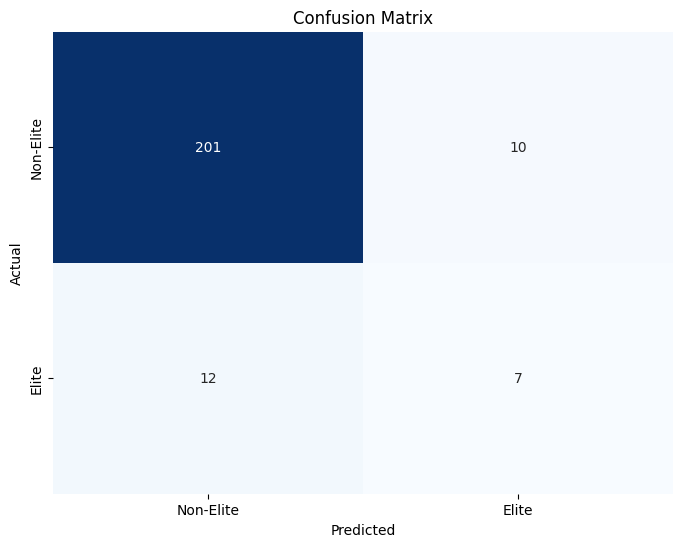

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, predictions_lof)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cbar=False, fmt='d', cmap='Blues', xticklabels=['Non-Elite', 'Elite'], yticklabels=['Non-Elite', 'Elite'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Elliptic Evolve



*   This algorithm fits a multivariate Gaussian distribution to the majority class and identifies anomalies based on deviations from this distribution. It assumes that the majority class is Gaussian distributed.



### Without Standarization:

In [ ]:
from sklearn.covariance import EllipticEnvelope

# Build Elliptic Envelope Model
model_ee = EllipticEnvelope(contamination=0.07)  # Adjust contamination based on your dataset
model_ee.fit(X_train)

predictions_ee = model_ee.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

predictions_ee = [1 if i==-1 else 0 for i in predictions_ee]
# Assuming y_test is your true labels
print(classification_report(y_test, predictions_ee))

# Calculate AUC-ROC
auc_roc = roc_auc_score(y_test, predictions_ee)
print(f'AUC-ROC: {auc_roc:.4f}')



              precision    recall  f1-score   support

           0       0.96      0.96      0.96       211
           1       0.55      0.58      0.56        19

    accuracy                           0.93       230
   macro avg       0.76      0.77      0.76       230
weighted avg       0.93      0.93      0.93       230

AUC-ROC: 0.7681


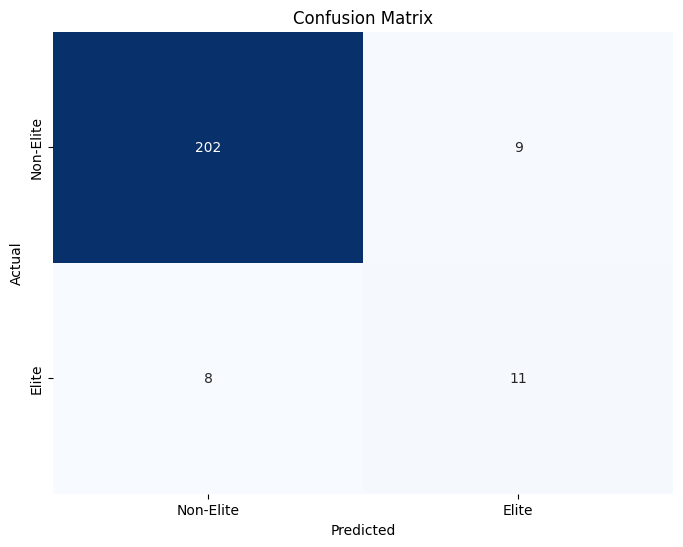

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, predictions_ee)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cbar=False, fmt='d', cmap='Blues', xticklabels=['Non-Elite', 'Elite'], yticklabels=['Non-Elite', 'Elite'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### With Standarization:

In [ ]:
from sklearn.covariance import EllipticEnvelope

# Build Elliptic Envelope Model
model_ee_scaled = EllipticEnvelope(contamination=0.07)  # Adjust contamination based on your dataset
model_ee_scaled.fit(X_train_scaled)

predictions_ee_scaled = model_ee_scaled.predict(X_test_scaled)

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

predictions_ee_scaled = [1 if i==-1 else 0 for i in predictions_ee_scaled]
# Assuming y_test is your true labels
print(classification_report(y_test, predictions_ee_scaled))

# Calculate AUC-ROC
auc_roc = roc_auc_score(y_test, predictions_ee_scaled)
print(f'AUC-ROC: {auc_roc:.4f}')



              precision    recall  f1-score   support

           0       0.96      0.94      0.95       211
           1       0.48      0.58      0.52        19

    accuracy                           0.91       230
   macro avg       0.72      0.76      0.74       230
weighted avg       0.92      0.91      0.92       230

AUC-ROC: 0.7610


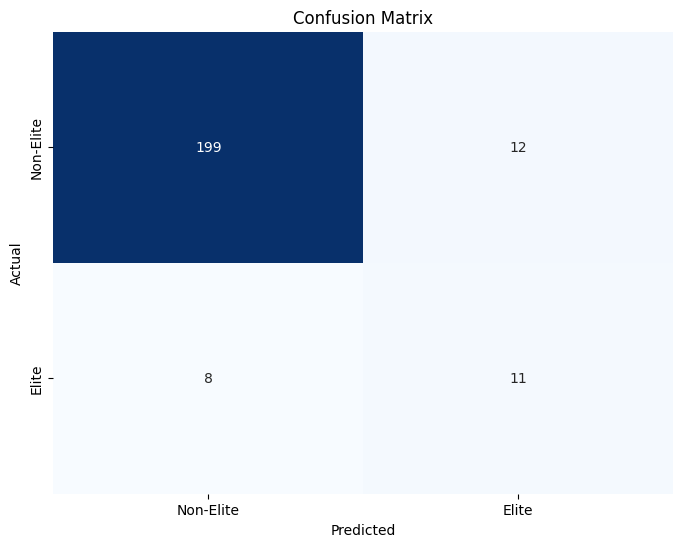

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, predictions_ee_scaled)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cbar=False, fmt='d', cmap='Blues', xticklabels=['Non-Elite', 'Elite'], yticklabels=['Non-Elite', 'Elite'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()